# Part 1: Introduction
In this set of practical exercises you will apply some of the concepts that you learned during the lectures to answer some questions.

All work will be based on data collected during a video game experiment. 

## A few words about the experiment
The main goal of the experiment was to collect physiological data from video-game players so that we can train machine learning models to recognize the players' emotions.

Groups of 2 or 4 subjects played a 10 minute round of a first person shooter game on the computer where the goal was to kill your opponent's character more times than they killed your own. Subjects could control the movement of their character with their left hand using the computer keyboard and could aim and fire their weapon with their right hand using the computer mouse. Players started with 100 health points and received damage when they were hit. When a player reached 0 health points they died and would be revived after a few seconds in a random location. If a player was able to kill two opponents before getting killed themselves, they were rewarded with an item that they could use to replenish 50 health points.

During gameplay, various data modalities were collected.
This data includes physiological data such as Electrodermal activity (EDA), Electrocardiogram (ECG), Respiration (Resp), left and right eye pupil dilation; Game data such as in-game health,  ; Annotations of the emotional dimensions of Arousal or Valence.

\* The data in this practical is a carefully selected subset of the experiment data making sure that the signals are of workable quality.

## Electrodermal activity (EDA)
This is a measure of the conductance of the skin. The value is proportional to the amount of sweat produced by the skin. This was measured through two electrodes attached on the index and middle fingers of the left hand (keyboard hand).

## Respiration (Respiration)
Respiration was measured by strapping an elastic sensor around a subject's chest and measuring the amount it stretched or contracted when their lungs inflated or deflated during the breathing cycle.

## Electrocardiogram (ECG)
This measures the electrical activity of the heart using electrodes attached to the subject's chest area. The ECG signal can be used to compute the heart rate of the subject.

## Heart rate (HR)
The heart rate as calculated from the ECG signal.

## Pupil dilation
An eyetracker was used to measure the subject's pupil dilation on each eye.

## Game data
- health: the player's amount of health points remaining
- inFOVenemy: 1 if an enemy is in the field of view, 0 otherwise 
- isReloading: 1 if player is in the process of reloading their weapon, 0 otherwise
- combat: 1 if the player is currently in combat (receiving or dealing damage), 0 otherwise

## Annotations
After subjects finished playing, they watched a playback of their gameplay and were asked to continuously annotate it (to the best of their recollection) according to one of two emotional dimensions: Arousal or Valence. For this practical we will focus on the arousal dimension.

Arousal is a measure of the perceived intensity of a particular event from very calming to very exciting or agitating.


## ? Question 1.1
What human factors can be measured using each of the physiological signals described above?

### ! Answer
<!-- Enter your answer below -->


## ? Question 1.2
What relationship do you think that arousal and valence will have with each of the game data described?

### ! Answer
<!-- Enter your answer below -->

## Load the data

In [1]:
import pandas as pd
#import pyarrow
import numpy as np

import HFtoolbox as tb

import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib widget

sampling_rate = 100
df_arsl = pd.read_parquet('data_arsl_subset.parquet')
#df_vlc = pd.read_parquet('data_vlc_subset.parquet')

In [2]:
list(df_arsl.columns)

['participantID',
 'gmi_time',
 'gmi_health',
 'gmi_isReloading',
 'gmi_inFOVenemy',
 'gmi_combat',
 'phy_time',
 'phy_EDA',
 'phy_ECG',
 'phy_HR',
 'phy_Respiration',
 'et_time',
 'et_left_pupil',
 'et_right_pupil',
 'rnk_time',
 'rnk_arousal']

## Signal filtering
Signals can be "noisy" due to various factors. To remove this noise and preserve as much of the signal integrity as we can, different filter types are used for different signals.
- For ECG, a bandpass filter is used that removes/attenuates frequencies outside of the range of 3Hz and 45Hz.
- For EDA, a low pass filter is used that removes/attenuates frequencies above 5Hz.
- For Respiration, a low pass filter is used that removes/attenuates frequencies above 2Hz.

## ? Question 1.3
What are some factors that can introduce noise to each of the signals? Why were these specific filter parameters used for each of the signals that we filtered in this part?

### ! Answer
<!-- Enter your answer below -->
- ECG: Different wavetypes are measured by an ECG, and each wave has it's own range of frequencies. T waves are in 0-10 Hz, P waves are in 5-30 Hz, QRS waves in 8-50 HZ. Moreover abnormal ventricular conduction is characterized by high frequencies, over 70 Hz.  
By bandpassing the signals, one manages to only get valid results, and filter out abnormal ventricular condution.  
  
- EDA: We apply this filter to remove repetitive distortions in the skin conductance signal that coincide with motion.  
  
- Respiration: 

# Part 2a: Inter-Participant variability in physiological signals
When dealing with physiological signals, it is often the case that the range of these signals is different between subjects. For example, subject A's heart rate might range from 60 to 140 but subject B's heart rate might range from 50 to 120.

This is a significant problem for machine learning methods using human data.

Of course, this issue is present in the dataset of this practical. Take a look at the EDA signals in the arousal dataframe here:

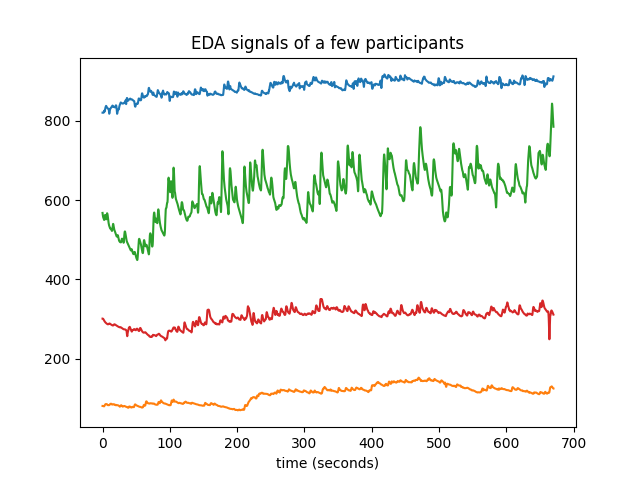

In [3]:
plt.close('eda1')
fig, ax = plt.subplots(num='eda1')
ax.set_title('EDA signals of a few participants')
ax.set_xlabel('time (seconds)')
df_arsl_groups = df_arsl.groupby(['participantID'])
cnt=0
for part,data in df_arsl_groups:
    plt.plot(data['phy_time']-data['phy_time'].min(), data['phy_EDA'])
    cnt+=1
    if cnt>=4:
        break

## ? Question 2.1
Brainstorm some potential causes for why there are these differences between participants in the physiological signals of this dataset. You are encouraged to do some research on your own about the nature of these physiological signals.

### ! Answer
<!-- Enter your answer below -->

## How to deal with inter-participant variability
It is common that the absolute value of a subject's physiological signal is not as important as the relative value of the signal at different points in time, hence why some different normalization techniques might be used to transform the signals of all subjects to a common range and potentially some other common statistical properties.

More advanced methods to deal with inter-participant variability also exist. For example, the mixed-effects model where the signal is assumed to be composed of a fixed effect that is independent from the individual subject and a random effect that is due to unique properties of a specific subject.

In this practical we will focus on two (of many) normalization techniques: standardization (Z-score) and min-max scaling.

### Standardization (Z-score)
The standardized signal $z$ is calculated as follows:
$$
z = \frac{x-\mu}{\sigma}
$$
where $x$ is the signal, $\mu$ is the mean of the signal, and $\sigma$ is the standard deviation of the signal.

### Min-max scaling
The scaled signal $x'$ is calculated as follows:
$$
x' = \frac{x-min(x)}{max(x)-min(x)}
$$
where $x$ is the signal, $min(x)$ is the minimum value of the signal, and $max(x)$ is the maximum value of the signal.

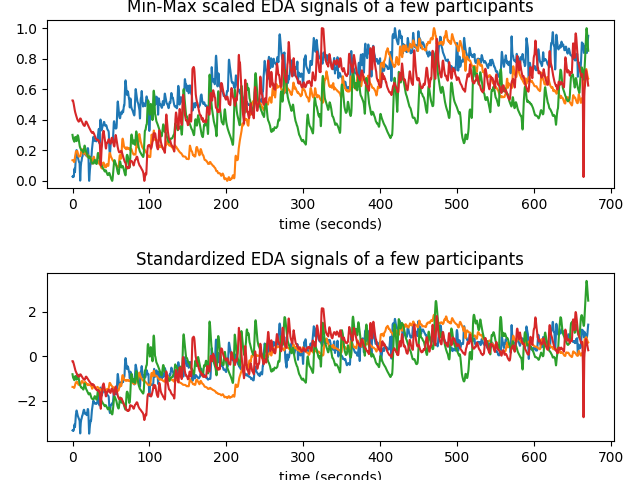

In [4]:
# Code example of min-max scaler and standardization on EDA signals
from sklearn.preprocessing import MinMaxScaler, StandardScaler

normalizer1 = MinMaxScaler()
normalizer2 = StandardScaler()

plt.close('eda2')
fig, ax = plt.subplots(2,num='eda2')
fig.tight_layout(h_pad=4)

ax[0].set_title('Min-Max scaled EDA signals of a few participants')
ax[0].set_xlabel('time (seconds)')
ax[1].set_title('Standardized EDA signals of a few participants')
ax[1].set_xlabel('time (seconds)')

df_arsl_groups = df_arsl.groupby(['participantID'])
cnt=0
for part,data in df_arsl_groups:
    phy_EDA_norm1 = normalizer1.fit_transform(data[['phy_EDA']])
    phy_EDA_norm2 = normalizer2.fit_transform(data[['phy_EDA']])
    ax[0].plot(data['phy_time']-data['phy_time'].min(), phy_EDA_norm1)
    ax[1].plot(data['phy_time']-data['phy_time'].min(), phy_EDA_norm2)
    cnt+=1
    if cnt>=4:
        break

## ? Question 2.2
What differences do you notice between the two normalization methods? What are some advantages and disadvantages between the two normalization methods? 

### ! Answer
<!-- Enter your answer below -->

# Part 2b: The importance of the target (Subjective vs Objective targets)

## Subjective targets
When working with human data, the target of the machine learning model is sometimes subjective. In our case, the target is emotional arousal and the only way for us to measure it is by asking the subjects (players). The subjects in our experiment were allowed to continuously rate the level of arousal on an unbounded scale (can go as high or as low as they want without restriction) using the mouse scroll wheel at the same time as they are rewatching their own recorded gameplay. As with the physiological signals, each subject annotation styles are different depending on their own biases, interpretation of the target, self-awareness, attention, and reaction time (how quickly can they interpret/reflect on the contents of the video and use the mouse scroll wheel to adjust the values)

We can apply similar techniques as before to normalize the subjective annotations, but we must be careful. An operation such as the min-max scaling can be problematic for the subjective annotations in this experiment. Remember the annotations have no bounds, so we cannot be sure of the absolute maximum/minimum value of arousal that a subject can possibly feel, we only know the maximum/minimum they felt for the duration of the experiment and in the context of the experiment. This is problematic because the maximum arousal of a subject during the experiment might still be very low compared to emotions they have felt outside of the experiment and therefore there may not be significant physiological responses. By min-max scaling the annotations we make a big assumption that the highest value of arousal for each subject will generate similarly strong physiological responses. Standardization will also have similar issues but we will use it later on anyway for simplicity.

Solutions to these issues is a very large topic and different methods are used depending on the experimental setup and annotation mechanism. It is something that you must always be aware of when working with subjective data. What is often done is to hire experts to annotate experiments, this somewhat reduces the variability of the annotations. An additional step would be to hire several experts to annotate the same experiment and aggregate the scores, resulting in even more consistent annotations.

## Objective targets
We can also use objective measurements as indicators for our desired target. Objective measures can be more desirable to work with since they are easier to normalize across subjects (physiological signals are objective measures!) These measures must be carefully selected based on prior research so as to not introduce experimenter/personal bias in the model results. For example, in this experiment we can make an assumption that combat events in the game are a good indicator for arousal. To most of you reading this, it seems like an intuitive assumption and you may accept it without question but just because the model is able to accurately predict combat events does not mean that it also predicts arousal. Separate prior experiments may need to be performed to verify indicators!

InvalidIndexError: (slice(None, None, None), None)

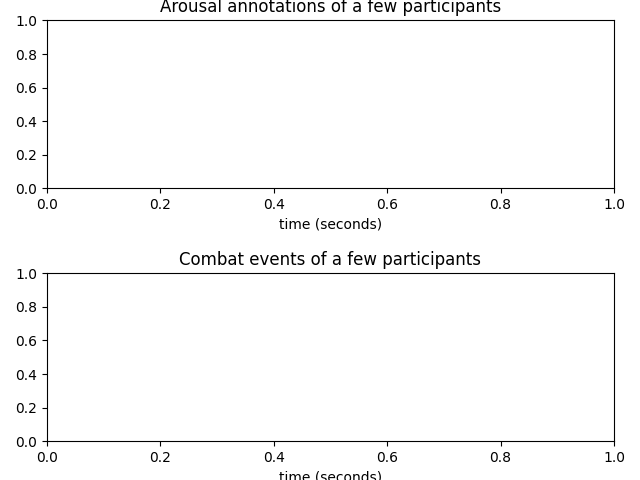

In [5]:
plt.close('target1')
fig, ax = plt.subplots(2, num='target1')
fig.tight_layout(h_pad=4)

ax[0].set_title('Arousal annotations of a few participants')
ax[0].set_xlabel('time (seconds)')
ax[1].set_title('Combat events of a few participants')
ax[1].set_xlabel('time (seconds)')

df_arsl_groups = df_arsl.groupby(['participantID'])
cnt=0
for part,data in df_arsl_groups:
    ax[0].plot(data['phy_time']-data['phy_time'].min(), data[['rnk_arousal']])
    combat_sumfilt = tb.extractFeatures(data['gmi_combat'], 1, ['sum'], win_duration=300, win_delay=0, step=1)
    # ax[1].plot(data['phy_time']-data['phy_time'].min(), data['gmi_combat'])
    ax[1].plot(data['phy_time']-data['phy_time'].min(), combat_sumfilt)
    cnt+=1
    if cnt>=4:
        break

In [ ]:
plt.close('target2')
fig, ax = plt.subplots( num='target2')
# fig.tight_layout(h_pad=4)

ax.set_title('Arousal annotation and combat events of a participant')
ax.set_xlabel('time (seconds)')
ax.set_ylabel('annotation',color='b')

df_arsl_groups = df_arsl.groupby(['participantID'])
cnt=0
for part,data in df_arsl_groups:
    ax.plot(data['phy_time']-data['phy_time'].min(), data[['rnk_arousal']],color='b')
    combat_sumfilt = tb.extractFeatures(data['gmi_combat'], 1, ['sum'], win_duration=300, win_delay=-300, step=1)
    # ax[1].plot(data['phy_time']-data['phy_time'].min(), data['gmi_combat'])
    axb = ax.twinx()
    axb.plot(data['phy_time']-data['phy_time'].min(), combat_sumfilt,color='r')
    axb.set_ylabel('combat',color='r')
    cnt+=1
    if cnt>=1:
        break


## ? Question 2.3
Reflect on the potential human factors and cognitive biases that cause the annotations of each subject to vary.

### ! Answer
<!-- Enter your answer below -->
HUMAN FACTORS:  
- Memory problems, the user might have forgotten the mindset they were in during the game, even though they are watching the replay.  
- Easiness of the task, it might be hard for someone to accuratly evaluete how aroused they were at a given point.  
- There will be a delay between watching a given scene, and giving your subjective answer, this delay will be different for each player.  
  
COGNITIVE BIASES:  
- Someone that is used to playing a lot of games, might be less aroused than someone that doesn't play at all by the same scenario.
- Someone that self reflects more about their own emotions, might be able to give more accurate answers than someone who is not.

# Part 3: Input/Target feature extraction
Depending on the machine learning method that we want to use, it may be advantageous to extract features from the signals which describe properties that are relevant to our particular context.

The use of features serves several purposes. Among others, it can...
- extract local or global properties of the signal which are highly correlated with the target variables. 
- overcome some of the inherent noise in the signal

Some examples of features:
- max/min: the maximum or minimum value of the signal
- mean: the local or global mean captures a summary of the amplitude of the signal
- variance: the variance captures how spread out the data points are in the signal
- main frequency: the main frequency component of the signal. Can be computed from a Fourier transform
- etc.

## Feature selection
It is often the case that we do not know exactly which features best correlated with the target. Furthermore, using too many features can make it more difficult for the model to be trained or it can cause the model to overfit. The goal is to use the minimum number of features that give a good performance.
One way to achieve this is to carefully select only the features which are highly correlated with the target.
Another way to achieve this is to perform principal component analysis (PCA) to project the features in a lower dimensional space where each component is orthogonal and maximizes the variance in that direction.

In [ ]:
# Physio signal features and PCA features vs arousal
from scipy.stats import spearmanr
from sklearn.decomposition import PCA

useFeatures = {'phy_EDA':['mean', 'median','min', 'max', 'variance']}
useTarget = {'rnk_arousal':['mean']} # rnk_valence for valence data
df = df_arsl # df_vlc for valence data!

nPCA = 3 # number of PCA components to compute

normalizer = StandardScaler()

target_key = list(useTarget.keys())[0]

In [ ]:
grouppart = df.groupby(['participantID']) 

featuresAll = pd.DataFrame()
targetAll = pd.DataFrame()
correlations = pd.DataFrame()
correlationsPCA = pd.DataFrame()

print('Computing feature correlations...')
for part,data in grouppart:
    # #remove missing points
    # data = data.dropna(subset=[target_key])
    
    #extract input features
    features = None
    for sig in useFeatures:
        # Normalize input signal
        sigNorm = np.squeeze(normalizer.fit_transform(data[[sig]]))
        sigFeatures = tb.extractFeatures(sigNorm, sampling_rate, useFeatures[sig], win_duration=5, win_delay=0, step=2)
        renameDict = {clm: sig[4:]+'_'+clm for clm in sigFeatures.columns}
        sigFeatures = sigFeatures.rename(columns =renameDict)
        if features is not None:
            features = features.join(sigFeatures)
        else:
            features = sigFeatures
    
    featureNames = list(features.columns)
    
    # compute target
    target_norm = np.squeeze(normalizer.fit_transform(data[[target_key]]))
    target_feat = tb.extractFeatures(target_norm, sampling_rate, useTarget[target_key], win_duration=5, win_delay=0, step=2)
    
    # calculate correlation of each feature with the target
    c,p = spearmanr(features.to_numpy(),target_feat.to_numpy())
    c = np.expand_dims(c[:-1,-1],0) #keep only the target correlations
    
    df_c = pd.DataFrame(data=c, columns=featureNames, index=[part])
    correlations = correlations.append(df_c)
    
    # perform PCA on the features
    pca = PCA(n_components=nPCA) # only keep the first three components
    featuresPCA = pca.fit_transform(features.to_numpy())
    featureNamesPCA = ['PCA{}'.format(n+1) for n in range(nPCA)]
    
    # calculate correlation of each feature with the target
    c,p = spearmanr(featuresPCA,target_feat.to_numpy())
    c = np.expand_dims(c[:-1,-1],0) #keep only the target correlations
    
    df_c = pd.DataFrame(data=c, columns=featureNamesPCA, index=[part])
    correlationsPCA = correlationsPCA.append(df_c)
    
print('done')



Computing feature correlations...
done


In [ ]:
plt.close('features1')
fig, ax = plt.subplots(2,num='features1')
fig.tight_layout(h_pad=4)

ax[0].set_title('Input features correlation with target')
ax[1].set_title('features PCA components correlation with target')

bx1 = ax[0].boxplot(correlations.abs(),labels=correlations.columns)
bx2 = ax[1].boxplot(correlationsPCA.abs(),labels=correlationsPCA.columns)


## ? Question 3.1
Based on the above results, if you had to choose **only one** feature to use in a machine learning model in the case where no PCA was performed, which would you choose? And in the case where PCA was performed? Is PCA better in this case, why/why not?

### ! Answer
<!-- Enter your answer below -->

## ? Question 3.2
Perform feature selection using additional signals and features and try to improve the PCA correlation with the target. What worked and what didn't? Give some explanation/opinions as to potential reasons.

### ! Answer
<!-- Enter your answer below -->

In [7]:
# Physio signal features and PCA features vs arousal
from scipy.stats import spearmanr
from sklearn.decomposition import PCA

useFeatures = {'phy_EDA':['mean','min', 'max']}
useTarget = {'rnk_arousal':['mean']} # rnk_valence for valence data
df = df_arsl # df_vlc for valence data!

nPCA = 3 # number of PCA components to compute

normalizer = StandardScaler()

target_key = list(useTarget.keys())[0]


grouppart = df.groupby(['participantID']) 

featuresAll = pd.DataFrame()
targetAll = pd.DataFrame()
correlations = pd.DataFrame()
correlationsPCA = pd.DataFrame()

print('Computing feature correlations...')
for part,data in grouppart:
    # #remove missing points
    # data = data.dropna(subset=[target_key])
    
    #extract input features
    features = None
    for sig in useFeatures:
        # Normalize input signal
        sigNorm = np.squeeze(normalizer.fit_transform(data[[sig]]))
        sigFeatures = tb.extractFeatures(sigNorm, sampling_rate, useFeatures[sig], win_duration=5, win_delay=0, step=2)
        renameDict = {clm: sig[4:]+'_'+clm for clm in sigFeatures.columns}
        sigFeatures = sigFeatures.rename(columns =renameDict)
        if features is not None:
            features = features.join(sigFeatures)
        else:
            features = sigFeatures
    
    featureNames = list(features.columns)
    
    # compute target
    target_norm = np.squeeze(normalizer.fit_transform(data[[target_key]]))
    target_feat = tb.extractFeatures(target_norm, sampling_rate, useTarget[target_key], win_duration=5, win_delay=0, step=2)
    
    # calculate correlation of each feature with the target
    c,p = spearmanr(features.to_numpy(),target_feat.to_numpy())
    c = np.expand_dims(c[:-1,-1],0) #keep only the target correlations
    
    df_c = pd.DataFrame(data=c, columns=featureNames, index=[part])
    correlations = correlations.append(df_c)
    
    # perform PCA on the features
    pca = PCA(n_components=nPCA) # only keep the first three components
    featuresPCA = pca.fit_transform(features.to_numpy())
    featureNamesPCA = ['PCA{}'.format(n+1) for n in range(nPCA)]
    
    # calculate correlation of each feature with the target
    c,p = spearmanr(featuresPCA,target_feat.to_numpy())
    c = np.expand_dims(c[:-1,-1],0) #keep only the target correlations
    
    df_c = pd.DataFrame(data=c, columns=featureNamesPCA, index=[part])
    correlationsPCA = correlationsPCA.append(df_c)
    
print('done')

Computing feature correlations...


C:\Users\Joao\AppData\Local\Temp\ipykernel_12928\1908679768.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correlations = correlations.append(df_c)
C:\Users\Joao\AppData\Local\Temp\ipykernel_12928\1908679768.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correlationsPCA = correlationsPCA.append(df_c)
C:\Users\Joao\AppData\Local\Temp\ipykernel_12928\1908679768.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correlations = correlations.append(df_c)
C:\Users\Joao\AppData\Local\Temp\ipykernel_12928\1908679768.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correlationsPCA = correlationsPCA.append(df_c)
C:\Users\Joao\Ap

done


C:\Users\Joao\AppData\Local\Temp\ipykernel_12928\1908679768.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correlationsPCA = correlationsPCA.append(df_c)


# Part 4: Machine learning
When selecting a model type/architecture for our machine learning problem there are several factors to consider:
 - **performance** - how well the model performs on the data
 - **generalization** - how well the model performs on unseen data
 - scalability - how resource-usage is affected by an increase in data
 - data efficiency - how much data is needed to achieve good performance
 - speed - how quickly can the model be trained, and how quickly can it make predictions
 - resource usage - how much memory, computation resources does the model need
 - and more ...

We will focus on the first two but depending on the application other factors may be equally important!

## Regression
With regression, we want to find a relationship between an input signal and a target. Then we can estimate the target using just the input signal or make predictions about the target based on a new input signal.

A common performance metric for regression that you may be familiar with is the mean squared error (MSE). It can be used to monitor the performance of your models as you make adjustments to the input features and model architecture/algorithm but when working with human data it is rarely a good measure to compare the performance of your models to models made by others. This is because different normalization techniques or other treatment of the target can have large effects on the MSE scores. A commonly used metric that is invariant to the target range is the Concordance Correlation Coefficient, this is often used to compare performance across different experiments.


In [8]:
# Get features for regression
useFeatures = {'phy_EDA':['median']} # input features to use
useTarget = {'rnk_arousal':['mean']} # target features
df = df_arsl 

normalizer = StandardScaler()

# For keeping it short we will only use the data of a single participant from the arousal dataset
data = df[df['participantID']==df['participantID'].unique()[0]] 
data = data.drop('participantID',axis=1)
# print(len(data))
rnk_key = list(useTarget.keys())[0]


#extract features
print('Extracting features...')
features = None
for sig in useFeatures:
    # Normalize input signal
    sigNorm = np.squeeze(normalizer.fit_transform(data[[sig]]))
    sigFeatures = tb.extractFeatures(sigNorm, sampling_rate, useFeatures[sig], win_duration=5, win_delay=0)
    renameDict = {clm: sig+'_'+clm for clm in sigFeatures.columns}
    sigFeatures = sigFeatures.rename(columns =renameDict)
    if features is not None:
        features = features.join(sigFeatures)
    else:
        features = sigFeatures
        
features = features.to_numpy()
print('Number of features: {}'.format(features.shape[1]))

#normalize the target
rnk_norm = np.squeeze(normalizer.fit_transform(data[[rnk_key]]))
target = tb.extractFeatures(rnk_norm, sampling_rate, useTarget[rnk_key], win_duration=5, win_delay=0).to_numpy()
# print(np.where(np.isnan(features)))
# win_starts = np.arange(200,len(data)-(500-200)+1,100)
# print(len(data))
# print(win_starts)
print('Done.')


Extracting features...
Number of features: 1
Done.


Fitting SVR model to the data...
Mean squared error: 0.9429730084707801


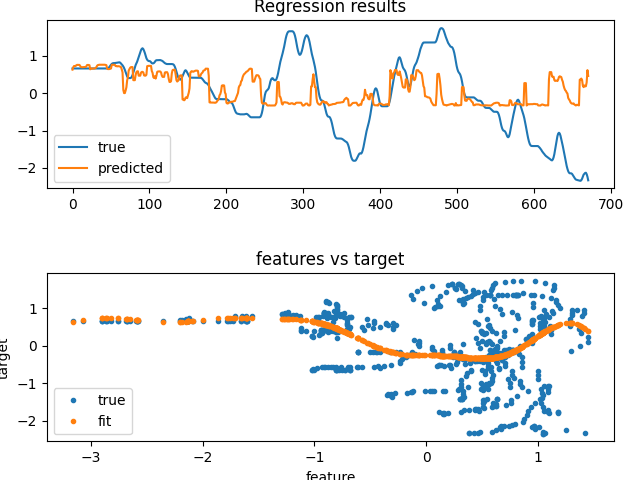

In [9]:
# Regression
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

# # perform PCA on the features
# pca = PCA(n_components=1) # only keep the first component
# features = pca.fit_transform(features)

# fit the svr model to the data
print('Fitting SVR model to the data...')
svr_rbf = SVR(kernel='rbf', C=100)
target_pred = svr_rbf.fit(features,np.squeeze(target)).predict(features)

# get performance metrics
mse = mean_squared_error(target,target_pred)
print('Mean squared error: {}'.format(mse))

plt.close('reg1')
fig, ax = plt.subplots(2,num='reg1')
fig.tight_layout(h_pad=4)
ax[0].set_title('Regression results')
ax[0].plot(target,label='true')
ax[0].plot(target_pred,label='predicted')
ax[0].legend()
ax[1].set_title('features vs target')
ax[1].set_xlabel('feature')
ax[1].set_ylabel('target')
ax[1].plot(features,target,'.', label='true')
ax[1].plot(features,target_pred,'.',label='fit')
ax[1].legend()


The regression results do not appear to be great, but as can be seen from the feature/target space the relationship between features and target is not one to one, and therefore the model will have a difficult time to fit this data.

## ? Question 4.1
Try doing regression using the **improved** PCA features (from Question 3.2), do you notice any differences in performance? How do the results and feature/target relationship look like now?

### ! Answer
With the use of PCA improved features, the MSE did improve a bit!
<!-- Enter your answer below -->

Extracting features...
Done.
Fitting SVR model to the data...
Mean squared error: 0.920187718898273


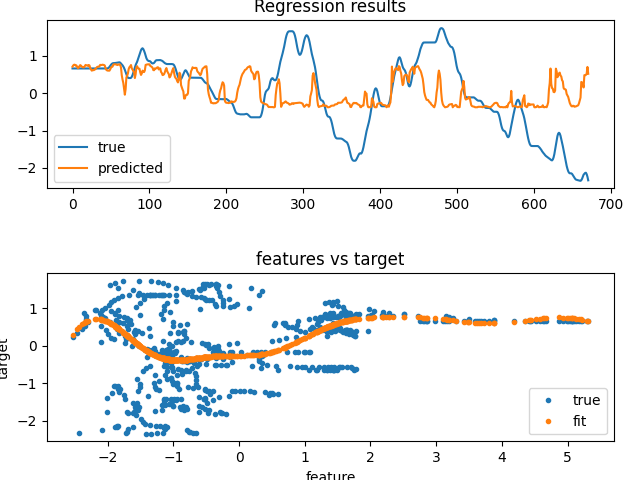

In [24]:
# Get features for regression
useFeatures = {'phy_EDA':['mean','min', 'max']} # input features to use
useTarget = {'rnk_arousal':['mean']} # target features
df = df_arsl 

normalizer = StandardScaler()

# For keeping it short we will only use the data of a single participant from the arousal dataset
data = df[df['participantID']==df['participantID'].unique()[0]] 
data = data.drop('participantID',axis=1)
# print(len(data))
rnk_key = list(useTarget.keys())[0]


#extract features
print('Extracting features...')
features = None
for sig in useFeatures:
    # Normalize input signal
    sigNorm = np.squeeze(normalizer.fit_transform(data[[sig]]))
    sigFeatures = tb.extractFeatures(sigNorm, sampling_rate, useFeatures[sig], win_duration=5, win_delay=0)
    renameDict = {clm: sig+'_'+clm for clm in sigFeatures.columns}
    sigFeatures = sigFeatures.rename(columns =renameDict)
    if features is not None:
        features = features.join(sigFeatures)
    else:
        features = sigFeatures
        
pca = PCA(n_components=1) 
featuresPCA = pca.fit_transform(features.to_numpy())
#print('Number of features: {}'.format(features.shape[1]))

#normalize the target
rnk_norm = np.squeeze(normalizer.fit_transform(data[[rnk_key]]))
target = tb.extractFeatures(rnk_norm, sampling_rate, useTarget[rnk_key], win_duration=5, win_delay=0).to_numpy()
# print(np.where(np.isnan(features)))
# win_starts = np.arange(200,len(data)-(500-200)+1,100)
# print(len(data))
# print(win_starts)
print('Done.')

# Regression
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

# # perform PCA on the features
# pca = PCA(n_components=1) # only keep the first component
# features = pca.fit_transform(features)

# fit the svr model to the data
print('Fitting SVR model to the data...')
svr_rbf = SVR(kernel='rbf', C=100)
target_pred = svr_rbf.fit(featuresPCA,np.squeeze(target)).predict(featuresPCA)

# get performance metrics
mse = mean_squared_error(target,target_pred)
print('Mean squared error: {}'.format(mse))

plt.close('reg1')
fig, ax = plt.subplots(2,num='reg1')
fig.tight_layout(h_pad=4)
ax[0].set_title('Regression results')
ax[0].plot(target,label='true')
ax[0].plot(target_pred,label='predicted')
ax[0].legend()
ax[1].set_title('features vs target')
ax[1].set_xlabel('feature')
ax[1].set_ylabel('target')
ax[1].plot(featuresPCA,target,'.', label='true')
ax[1].plot(featuresPCA,target_pred,'.',label='fit')
ax[1].legend()

## Classification
With classification, we want to assign one or more categories (or classes) to the input signal.

In this practical we can also perform classification. First, we need to derive classes from our target data. We can do this easily by "binning" the continuous data into high, low, and neutral classes. For example, if we want to bin a continuous signal which ranges from 0 to 1 we may "bin" it into 3 categories as follows: 
- low (0-0.33)
- neutral (0.33-0.66)
- high (0.66-1).

Support vector machines (SVM) were a popular classification model to use, so we will use this here as well.

### class balancing
When it comes to classification of human data, classes are often imbalanced. What this means is that we may have more data about one class compared to another. This results in the model to overfit to one class and give misleading performance results. Therefore, it is very important to check if classes are balanced and to implement class balancing techniques before training a model.



In [11]:
# get features for classification
useFeatures = {'phy_EDA':['median']}
useTarget = {'rnk_arousal':['median']} # 
df = df_arsl #

normalizer = StandardScaler()

# For keeping it short we will only use the data of a single participant from the arousal datase
data = df[df['participantID']==df['participantID'].unique()[0]] 
data = data.drop('participantID',axis=1)

rnk_key = list(useTarget.keys())[0]

#remove missing points
data = data.dropna(subset=[rnk_key])

#extract features
print('Extracting features...')
features = None
for sig in useFeatures:
    # Normalize input signal
    sigNorm = np.squeeze(normalizer.fit_transform(data[[sig]]))
    sigFeatures = tb.extractFeatures(sigNorm, sampling_rate, useFeatures[sig], win_duration=5, win_delay=0)
    renameDict = {clm: sig+'_'+clm for clm in sigFeatures.columns}
    sigFeatures = sigFeatures.rename(columns =renameDict)
    if features is not None:
        features = features.join(sigFeatures)
    else:
        features = sigFeatures
        
features = features.to_numpy()

#normalize the target
rnk_norm = np.squeeze(normalizer.fit_transform(data[[rnk_key]]))
#compute classes
rnk_classes = tb.bin_signal(rnk_norm, bins=3) # bins=number of classes
targetClasses = tb.extractFeatures(rnk_classes, sampling_rate, useTarget[rnk_key], win_duration=5, win_delay=0).to_numpy().astype(int)

unique, counts = np.unique(targetClasses, return_counts=True)
class_counts = dict(zip(unique, counts)) 
print('Number of features: {}'.format(features.shape[1]))
print('class counts: {}'.format(class_counts))

Extracting features...
Number of features: 1
class counts: {0: 136, 1: 237, 2: 298}


In [12]:
# Classification
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

# class balancing (default is a weight of 1 for each class)
weights = {0:1, 1:1, 2:1} # class labels are 0,1, and 2
# For question 4.3, assign the weights to balance the classes according to the class_counts

# # perform PCA on the features
# pca = PCA(n_components=1) # only keep the first component
# features = pca.fit_transform(features)

# fit the svr model to the data
print('Fitting SVM model to the data...')
svc_rbf = SVC(kernel='rbf', class_weight=weights)
targetClasses_pred = svc_rbf.fit(features,np.squeeze(targetClasses)).predict(features)

# get performance metrics
conf_matrix = confusion_matrix(np.squeeze(targetClasses),np.squeeze(targetClasses_pred))
print('Confusion matrix:')
print(conf_matrix)

Fitting SVM model to the data...
Confusion matrix:
[[  5  96  35]
 [  5 163  69]
 [ 10  85 203]]


## ? Question 4.2
Compute the precision, recall, and Cohen's Kappa from the confusion matrix.

### ! Answer
<!-- Enter your answer below -->
CODE BELOW  

In [13]:
def computeAll(confusion):
    precisions = [round(confusion[i][i]/np.sum(confusion[:,i]),2) for i in range(len(confusion))]
    print("Precisions : ", precisions)
    recalls = [round(confusion[i][i]/np.sum(confusion[i,:]),2) for i in range(len(confusion))]
    print("Recalls : ", recalls)
    
    total = np.sum([np.sum(confusion[:,i]) for i in range(len(confusion))])
    R = np.sum([(np.sum(confusion[:,i])/total)*(np.sum(confusion[i,:])/total) for i in range(len(confusion))])
    A = np.sum([confusion[i][i] for i in range(len(confusion))])/total
    K = round((A-R)/(1-R),2)
    print("Cohen's Kappa : ",K)

    return precisions, recalls, K

print(conf_matrix)
print()
computeAll(conf_matrix)

[[  5  96  35]
 [  5 163  69]
 [ 10  85 203]]

Precisions :  [0.25, 0.47, 0.66]
Recalls :  [0.04, 0.69, 0.68]
Cohen's Kappa :  0.27


([0.25, 0.47, 0.66], [0.04, 0.69, 0.68], 0.27)

## ? Question 4.3
Use the `class_counts` variable to calculate the necessary `weights` for each class such that they are balanced. Do this programmatically in the provided code. Do not hardcode values! 

Then fit the model using these weights. How do the results differ?

Try using the PCA feature now, how did the performance change?

### ! Answer
Both the recalls and the precisions changed, some classes for the better, others a little bit worse, however cohens kappa go worse with the weighted classes!  
With and without PCA.
<!-- Enter your answer below -->

In [21]:
def computeWeights(count):
    return {i:round(np.sum([j for _,j in count.items()])/(2*j),2) for i,j in count.items()}


print('Fitting SVM model to the data...')
svc_rbf = SVC(kernel='rbf', class_weight=computeWeights(class_counts))
targetClasses_pred = svc_rbf.fit(features,np.squeeze(targetClasses)).predict(features)

# get performance metrics
conf_matrix = confusion_matrix(np.squeeze(targetClasses),np.squeeze(targetClasses_pred))
print('Confusion matrix:')
print(conf_matrix)
print()
computeAll(conf_matrix)


print()


# # perform PCA on the features
pca = PCA(n_components=1) # only keep the first component
features = pca.fit_transform(features)

# fit the svr model to the data
print('Fitting SVM model to the data...')
svc_rbf = SVC(kernel='rbf', class_weight=computeWeights(class_counts))
targetClasses_pred = svc_rbf.fit(features,np.squeeze(targetClasses)).predict(features)

# get performance metrics
conf_matrix = confusion_matrix(np.squeeze(targetClasses),np.squeeze(targetClasses_pred))
print('Confusion matrix:')
print(conf_matrix)
print()
computeAll(conf_matrix)


Fitting SVM model to the data...
Confusion matrix:
[[129   7   0]
 [172  26  39]
 [133  15 150]]

Precisions :  [0.3, 0.54, 0.79]
Recalls :  [0.95, 0.11, 0.5]
Cohen's Kappa :  0.24

Fitting SVM model to the data...
Confusion matrix:
[[129   7   0]
 [172  26  39]
 [133  15 150]]

Precisions :  [0.3, 0.54, 0.79]
Recalls :  [0.95, 0.11, 0.5]
Cohen's Kappa :  0.24


([0.3, 0.54, 0.79], [0.95, 0.11, 0.5], 0.24)

## ? Question 4.4
Try doing classification using the **improved** PCA features (from Question 3.2), do you notice any differences in performance?

### ! Answer
<!-- Enter your answer below -->

## ? Question 4.5
So far, we have been making participant-specific models (i.e. using the data of a single participant) by using all of that participants data to train the model. This may lead to overfitting to the data, what are some strategies to overcome this and make a better model for this participant such that when we collect new data from the same participant we can apply the model on this new data with good results?

### ! Answer
<!-- Enter your answer below -->

## ? Question 4.6
Now imagine that we want to make a model that can perform well on data of a completely new participant that we have not recorded yet. Among the entire data that is available in this practical (20 participants), how should we select the training data for this model and what cross validation strategy should we implement?

### ! Answer
<!-- Enter your answer below -->

# Part B: Bonus
This part is **optional**. You may answer the questions in this part for extra points in case you are interested to go deeper.


## ? Question B.1
Implement a training loop using the cross-validation from your answer in Question 4.6 for either the regression or classification using the entire dataset (all 20 participants)

Describe the cross-validation strategy and report your results.

### ! Answer
<!-- Enter your answer below -->

In [ ]:
# Code for Question B.1
# TODO!
